# Building scenarios

Pymagicc offers the ability to join/merge scenarios to create custom scenarios. Here we show a minimal working example of how to do this.

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join
from datetime import datetime

import pandas as pd

from pymagicc import MAGICC6
from pymagicc.io import MAGICCData
from pymagicc.definitions import (
    convert_magicc7_to_openscm_variables,
    PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1,
)
from scmdata import run_append

import expectexception

import matplotlib.pyplot as plt

plt.style.use("bmh")
%matplotlib inline

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
DATA_DIR = join("..", "tests", "test_data")
DATA_MAGICC6_RUN = join("..", "pymagicc", "MAGICC6", "run")

We start by reading in our raw data. As the formats we're reading don't have any easily readable metadata, we set it using the `columns` argument. 

**Note**: The `model` column refers to the model which generated the scenario (typically an integrated assessment model), with the `climate_model` column being saved for storing the climate model which was used to do climate projections.

In [3]:
rcp3pd = MAGICCData(
    join(DATA_DIR, "RCP3PD_EMISSIONS.DAT"),
    columns={"model": "IMAGE", "scenario": "RCP3PD"},
)
rcp3pd.head()

time                                                                                                               1765-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                                         
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  MAGICC6.3.09, 25 November 2009                0.003   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  MAGICC6.3.09, 25 November 2009                0.000   
               Mt CH4 / yr  Emissions|CH4                              World  SET  MAGICC6.3.09, 25 November 2009                0.000   
               Mt N2ON / yr Emissions|N2O                              World  SET  MAGICC6.3.09, 25 November 2009                0.000   
               Mt S / yr    Emissions|SOx                              World  SET  MAGICC6.3.09, 25 November 2009                0.000   

time                                                                                                               1766-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                                         
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  MAGICC6.3.09, 25 November 2009             0.003000   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  MAGICC6.3.09, 25 November 2009             0.005338   
               Mt CH4 / yr  Emissions|CH4                              World  SET  MAGICC6.3.09, 25 November 2009             1.963262   
               Mt N2ON / yr Emissions|N2O                              World  SET  MAGICC6.3.09, 25 November 2009             0.005191   
               Mt S / yr    Emissions|SOx                              World  SET  MAGICC6.3.09, 25 November 2009             0.098883   

time                                                                                                               1767-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                                         
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  MAGICC6.3.09, 25 November 2009             0.003000   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  MAGICC6.3.09, 25 November 2009             0.010677   
               Mt CH4 / yr  Emissions|CH4                              World  SET  MAGICC6.3.09, 25 November 2009             2.436448   
               Mt N2ON / yr Emissions|N2O                              World  SET  MAGICC6.3.09, 25 November 2009             0.010117   
               Mt S / yr    Emissions|SOx                              World  SET  MAGICC6.3.09, 25 November 2009             0.116306   

time                                                                                                               1768-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                                         
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  MAGICC6.3.09, 25 November 2009             0.003000   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  MAGICC6.3.09, 25 November 2009             0.016015   
               Mt CH4 / yr  Emissions|CH4                              World  SET  MAGICC6.3.09, 25 November 2009             2.911105   
               Mt N2ON / yr Emissions|N2O                              World  SET  MAGICC6.3.09, 25 November 2009             0.015043   
               Mt S / yr    Emissions|SOx                              World  SET  MAGICC6.3.09, 25 November 2009             0.133811   

time                                                                                                               1769-01-01 00:00:

This data came from MAGICC6.3.09, in order to set it up for a new run, we have to strip out that information.

In [4]:
rcp3pd["climate_model"] = "unspecified"
rcp3pd.head()

time                                                                                              1765-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                        
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified                  0.003   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified                  0.000   
               Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified                  0.000   
               Mt N2ON / yr Emissions|N2O                              World  SET  unspecified                  0.000   
               Mt S / yr    Emissions|SOx                              World  SET  unspecified                  0.000   

time                                                                                              1766-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                        
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.005338   
               Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified               1.963262   
               Mt N2ON / yr Emissions|N2O                              World  SET  unspecified               0.005191   
               Mt S / yr    Emissions|SOx                              World  SET  unspecified               0.098883   

time                                                                                              1767-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                        
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.010677   
               Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified               2.436448   
               Mt N2ON / yr Emissions|N2O                              World  SET  unspecified               0.010117   
               Mt S / yr    Emissions|SOx                              World  SET  unspecified               0.116306   

time                                                                                              1768-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                        
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.016015   
               Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified               2.911105   
               Mt N2ON / yr Emissions|N2O                              World  SET  unspecified               0.015043   
               Mt S / yr    Emissions|SOx                              World  SET  unspecified               0.133811   

time                                                                                              1769-01-01 00:00:00  \
model scenario unit         variable                                   region todo climate_model                        
IMAGE RCP3PD   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                            Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.021353   
               Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified               3.387278   
   

In [5]:
rcp85 = MAGICCData(
    join(DATA_MAGICC6_RUN, "RCP85.SCEN"),
    columns={"model": "MESSAGE", "scenario": "RCP85"},
)
rcp85["climate_model"] = "unspecified"
rcp85.head()

time                                                                                                       2000-01-01 00:00:00  \
model   scenario variable                                   unit         todo region        climate_model                        
MESSAGE RCP85    Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    SET  World|Bunkers unspecified                 0.0000   
                 Emissions|CO2|MAGICC AFOLU                 Gt C / yr    SET  World|Bunkers unspecified                 0.0000   
                 Emissions|CH4                              Mt CH4 / yr  SET  World|Bunkers unspecified                 0.4325   
                 Emissions|N2O                              Mt N2ON / yr SET  World|Bunkers unspecified                 0.0000   
                 Emissions|SOx                              Mt S / yr    SET  World|Bunkers unspecified                 5.5390   

time                                                                                                       2001-01-01 00:00:00  \
model   scenario variable                                   unit         todo region        climate_model                        
MESSAGE RCP85    Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    SET  World|Bunkers unspecified                 0.0000   
                 Emissions|CO2|MAGICC AFOLU                 Gt C / yr    SET  World|Bunkers unspecified                 0.0000   
                 Emissions|CH4                              Mt CH4 / yr  SET  World|Bunkers unspecified                 0.4422   
                 Emissions|N2O                              Mt N2ON / yr SET  World|Bunkers unspecified                 0.0000   
                 Emissions|SOx                              Mt S / yr    SET  World|Bunkers unspecified                 5.5824   

time                                                                                                       2002-01-01 00:00:00  \
model   scenario variable                                   unit         todo region        climate_model                        
MESSAGE RCP85    Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    SET  World|Bunkers unspecified                 0.0000   
                 Emissions|CO2|MAGICC AFOLU                 Gt C / yr    SET  World|Bunkers unspecified                 0.0000   
                 Emissions|CH4                              Mt CH4 / yr  SET  World|Bunkers unspecified                 0.4520   
                 Emissions|N2O                              Mt N2ON / yr SET  World|Bunkers unspecified                 0.0000   
                 Emissions|SOx                              Mt S / yr    SET  World|Bunkers unspecified                 5.6207   

time                                                                                                       2003-01-01 00:00:00  \
model   scenario variable                                   unit         todo region        climate_model                        
MESSAGE RCP85    Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    SET  World|Bunkers unspecified                 0.0000   
                 Emissions|CO2|MAGICC AFOLU                 Gt C / yr    SET  World|Bunkers unspecified                 0.0000   
                 Emissions|CH4                              Mt CH4 / yr  SET  World|Bunkers unspecified                 0.4618   
                 Emissions|N2O                              Mt N2ON / yr SET  World|Bunkers unspecified                 0.0000   
                 Emissions|SOx                              Mt S / yr    SET  World|Bunkers unspecified                 5.6587   

time                                                                                                       2004-01-01 00:00:00  \
model   scenario variable                                   unit         todo region        climate_model                        
MESSAGE RCP85    Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    SET  World|Bunkers unsp

To join the data, we first have to do a little bit of preparation. Specifically, we must make sure that the metadata for the timeseries we want to prepare is the same which means re-writing the model and scenario columns.

In [6]:
my_scen_hist = rcp3pd.copy()
my_scen_hist["model"] = "idealised"
my_scen_hist["scenario"] = "custom"

my_scen_future = rcp85.copy()
my_scen_future["model"] = "idealised"
my_scen_future["scenario"] = "custom"

my_scen_future.tail()

time                                                                              2000-01-01 00:00:00  \
model     scenario variable           unit             todo region climate_model                        
idealised custom   Emissions|HFC134a  kt HFC134a / yr  SET  World  unspecified                75.0394   
                   Emissions|HFC143a  kt HFC143a / yr  SET  World  unspecified                 6.2341   
                   Emissions|HFC227ea kt HFC227ea / yr SET  World  unspecified                 1.9510   
                   Emissions|HFC245fa kt HFC245fa / yr SET  World  unspecified                17.9257   
                   Emissions|SF6      kt SF6 / yr      SET  World  unspecified                 5.5382   

time                                                                              2001-01-01 00:00:00  \
model     scenario variable           unit             todo region climate_model                        
idealised custom   Emissions|HFC134a  kt HFC134a / yr  SET  World  unspecified                84.0409   
                   Emissions|HFC143a  kt HFC143a / yr  SET  World  unspecified                 7.4947   
                   Emissions|HFC227ea kt HFC227ea / yr SET  World  unspecified                 1.6450   
                   Emissions|HFC245fa kt HFC245fa / yr SET  World  unspecified                19.7183   
                   Emissions|SF6      kt SF6 / yr      SET  World  unspecified                 5.6990   

time                                                                              2002-01-01 00:00:00  \
model     scenario variable           unit             todo region climate_model                        
idealised custom   Emissions|HFC134a  kt HFC134a / yr  SET  World  unspecified                94.7162   
                   Emissions|HFC143a  kt HFC143a / yr  SET  World  unspecified                 8.7389   
                   Emissions|HFC227ea kt HFC227ea / yr SET  World  unspecified                 2.5080   
                   Emissions|HFC245fa kt HFC245fa / yr SET  World  unspecified                21.5109   
                   Emissions|SF6      kt SF6 / yr      SET  World  unspecified                 5.8596   

time                                                                              2003-01-01 00:00:00  \
model     scenario variable           unit             todo region climate_model                        
idealised custom   Emissions|HFC134a  kt HFC134a / yr  SET  World  unspecified               101.4157   
                   Emissions|HFC143a  kt HFC143a / yr  SET  World  unspecified                 9.9776   
                   Emissions|HFC227ea kt HFC227ea / yr SET  World  unspecified                 3.3410   
                   Emissions|HFC245fa kt HFC245fa / yr SET  World  unspecified                23.3034   
                   Emissions|SF6      kt SF6 / yr      SET  World  unspecified                 6.0202   

time                                                                              2004-01-01 00:00:00  \
model     scenario variable           unit             todo region climate_model                        
idealised custom   Emissions|HFC134a  kt HFC134a / yr  SET  World  unspecified               113.9297   
                   Emissions|HFC143a  kt HFC143a / yr  SET  World  unspecified                11.2136   
                   Emissions|HFC227ea kt HFC227ea / yr SET  World  unspecified                 4.2690   
                   Emissions|HFC245fa kt HFC245fa / yr SET  World  unspecified                25.0960   
                   Emissions|SF6      kt SF6 / yr      SET  World  unspecified                 6.1806   

time                                                                              2005-01-01 00:00:00  \
model     scenario variable           unit             todo region climate_model                        
idealised custom   Emissions|HFC134a  kt HFC134a / yr  SET  World  unspecified               120.9334   
     

To then join the data, we can simply filter the data and then append one onto the other. 

In [7]:
# NBVAL_IGNORE_OUTPUT
my_scen_hist.filter(year=range(1, 2006)).head()

time                                                                                                  1765-01-01  \
model     scenario unit         variable                                   region todo climate_model               
idealised custom   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified         0.003   
                                Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified         0.000   
                   Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified         0.000   
                   Mt N2ON / yr Emissions|N2O                              World  SET  unspecified         0.000   
                   Mt S / yr    Emissions|SOx                              World  SET  unspecified         0.000   

time                                                                                                  1766-01-01  \
model     scenario unit         variable                                   region todo climate_model               
idealised custom   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified      0.003000   
                                Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified      0.005338   
                   Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified      1.963262   
                   Mt N2ON / yr Emissions|N2O                              World  SET  unspecified      0.005191   
                   Mt S / yr    Emissions|SOx                              World  SET  unspecified      0.098883   

time                                                                                                  1767-01-01  \
model     scenario unit         variable                                   region todo climate_model               
idealised custom   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified      0.003000   
                                Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified      0.010677   
                   Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified      2.436448   
                   Mt N2ON / yr Emissions|N2O                              World  SET  unspecified      0.010117   
                   Mt S / yr    Emissions|SOx                              World  SET  unspecified      0.116306   

time                                                                                                  1768-01-01  \
model     scenario unit         variable                                   region todo climate_model               
idealised custom   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified      0.003000   
                                Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified      0.016015   
                   Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified      2.911105   
                   Mt N2ON / yr Emissions|N2O                              World  SET  unspecified      0.015043   
                   Mt S / yr    Emissions|SOx                              World  SET  unspecified      0.133811   

time                                                                                                  1769-01-01  \
model     scenario unit         variable                                   region todo climate_model               
idealised custom   Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified      0.003000   
                                Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified      0.021353   
                   Mt CH4 / yr  Emissions|CH4                              World  SET  unspecified      3.387278   
                   Mt N2ON / yr Emissions|N2O                              World  SET  unspecified      0.019969   
                   Mt S / yr    Emissions|SOx       

In [8]:
# NBVAL_IGNORE_OUTPUT
rcp3pd_up_to_2005 = my_scen_hist.filter(year=range(1, 2006))
rcp85_2006_onwards = my_scen_future.filter(year=range(2006, 30000))
# TODO: fix openscm method so it checks for duplicate time points, not duplicate index...
my_scen = rcp3pd_up_to_2005.append(rcp85_2006_onwards, duplicate_msg="warn")
my_scen["time"].head()

/home/jared/code/uom/pymagicc/venv/lib/python3.7/site-packages/scmdata/run.py:1985: UserWarning: Duplicate time points detected, the output will be the average of the duplicates.  Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)


0    1765-01-01 00:00:00
1    1766-01-01 00:00:00
2    1767-01-01 00:00:00
3    1768-01-01 00:00:00
4    1769-01-01 00:00:00
Name: time, dtype: object

In [9]:
# NBVAL_IGNORE_OUTPUT
my_scen["time"].tail()

261    2300-01-01 00:00:00
262    2350-01-01 00:00:00
263    2400-01-01 00:00:00
264    2450-01-01 00:00:00
265    2500-01-01 00:00:00
Name: time, dtype: object

Note that appending in this way keeps all of the available data. This means that we still have regional data over the future.

In [10]:
# NBVAL_IGNORE_OUTPUT
my_scen.filter(region="World", keep=False).head()

time                                                                                                        1765-01-01 00:00:00  \
model     scenario variable                                   unit        todo region        climate_model                        
idealised custom   Emissions|CO2|MAGICC AFOLU                 Gt C / yr   SET  World|Bunkers unspecified                    NaN   
                   Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   SET  World|Bunkers unspecified                    NaN   
                   Emissions|BC                               Mt BC / yr  SET  World|Bunkers unspecified                    NaN   
                   Emissions|CH4                              Mt CH4 / yr SET  World|Bunkers unspecified                    NaN   
                   Emissions|CO                               Mt CO / yr  SET  World|Bunkers unspecified                    NaN   

time                                                                                                        1766-01-01 00:00:00  \
model     scenario variable                                   unit        todo region        climate_model                        
idealised custom   Emissions|CO2|MAGICC AFOLU                 Gt C / yr   SET  World|Bunkers unspecified                    NaN   
                   Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   SET  World|Bunkers unspecified                    NaN   
                   Emissions|BC                               Mt BC / yr  SET  World|Bunkers unspecified                    NaN   
                   Emissions|CH4                              Mt CH4 / yr SET  World|Bunkers unspecified                    NaN   
                   Emissions|CO                               Mt CO / yr  SET  World|Bunkers unspecified                    NaN   

time                                                                                                        1767-01-01 00:00:00  \
model     scenario variable                                   unit        todo region        climate_model                        
idealised custom   Emissions|CO2|MAGICC AFOLU                 Gt C / yr   SET  World|Bunkers unspecified                    NaN   
                   Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   SET  World|Bunkers unspecified                    NaN   
                   Emissions|BC                               Mt BC / yr  SET  World|Bunkers unspecified                    NaN   
                   Emissions|CH4                              Mt CH4 / yr SET  World|Bunkers unspecified                    NaN   
                   Emissions|CO                               Mt CO / yr  SET  World|Bunkers unspecified                    NaN   

time                                                                                                        1768-01-01 00:00:00  \
model     scenario variable                                   unit        todo region        climate_model                        
idealised custom   Emissions|CO2|MAGICC AFOLU                 Gt C / yr   SET  World|Bunkers unspecified                    NaN   
                   Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   SET  World|Bunkers unspecified                    NaN   
                   Emissions|BC                               Mt BC / yr  SET  World|Bunkers unspecified                    NaN   
                   Emissions|CH4                              Mt CH4 / yr SET  World|Bunkers unspecified                    NaN   
                   Emissions|CO                               Mt CO / yr  SET  World|Bunkers unspecified                    NaN   

time                                                                                                        1769-01-01 00:00:00  \
model     scenario variable                                   unit        todo region        climate_model                        
idealised custom   Emissions|CO2|MAGICC AFOLU                 Gt C

We can remove this by simply filtering our scenario once again.

In [11]:
# NBVAL_IGNORE_OUTPUT
my_scen_world = my_scen.filter(region="World")
my_scen_world.head()

time                                                                                                 1765-01-01 00:00:00  \
model     scenario unit        variable                                   region todo climate_model                        
idealised custom   Gt C / yr   Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified                  0.000   
                               Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified                  0.003   
                   Mt BC / yr  Emissions|BC                               World  SET  unspecified                  0.000   
                   Mt CH4 / yr Emissions|CH4                              World  SET  unspecified                  0.000   
                   Mt CO / yr  Emissions|CO                               World  SET  unspecified                  0.000   

time                                                                                                 1766-01-01 00:00:00  \
model     scenario unit        variable                                   region todo climate_model                        
idealised custom   Gt C / yr   Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.005338   
                               Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                   Mt BC / yr  Emissions|BC                               World  SET  unspecified               0.106998   
                   Mt CH4 / yr Emissions|CH4                              World  SET  unspecified               1.963262   
                   Mt CO / yr  Emissions|CO                               World  SET  unspecified               9.050221   

time                                                                                                 1767-01-01 00:00:00  \
model     scenario unit        variable                                   region todo climate_model                        
idealised custom   Gt C / yr   Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.010677   
                               Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                   Mt BC / yr  Emissions|BC                               World  SET  unspecified               0.133383   
                   Mt CH4 / yr Emissions|CH4                              World  SET  unspecified               2.436448   
                   Mt CO / yr  Emissions|CO                               World  SET  unspecified              12.960844   

time                                                                                                 1768-01-01 00:00:00  \
model     scenario unit        variable                                   region todo climate_model                        
idealised custom   Gt C / yr   Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.016015   
                               Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                   Mt BC / yr  Emissions|BC                               World  SET  unspecified               0.159847   
                   Mt CH4 / yr Emissions|CH4                              World  SET  unspecified               2.911105   
                   Mt CO / yr  Emissions|CO                               World  SET  unspecified              16.876539   

time                                                                                                 1769-01-01 00:00:00  \
model     scenario unit        variable                                   region todo climate_model                        
idealised custom   Gt C / yr   Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.021353   
                               Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                   Mt BC / y

We can check the results as shown.

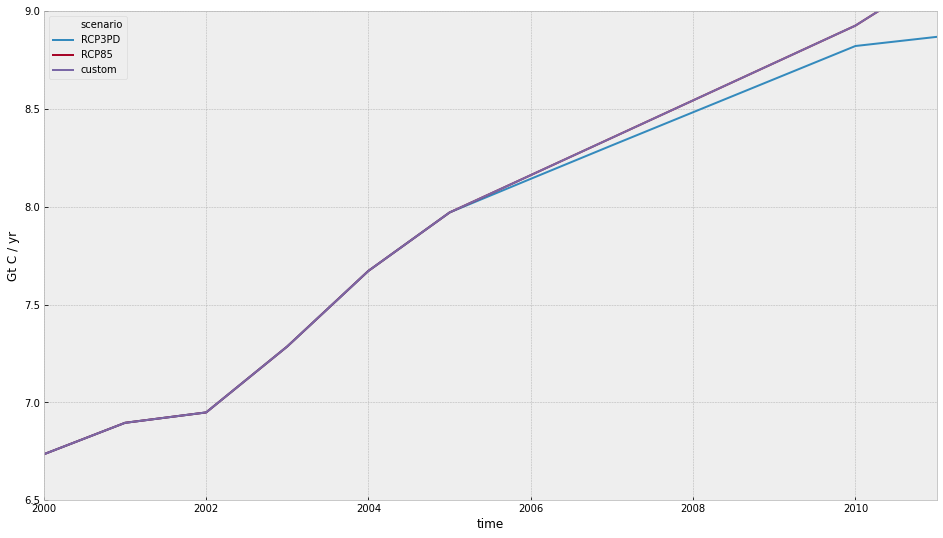

In [12]:
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

plt.figure(figsize=(16, 9))

ax = (
    run_append([rcp3pd, rcp85, my_scen_world])
    .filter(region="World", variable=var_to_plot)
    .lineplot(x="time", hue="scenario")
)
ax.set_xlim([datetime(2000, 1, 1), datetime(2011, 1, 1)])
ax.set_ylim([6.5, 9]);

If we put our scenario into a MAGICCData object, we can run it using Pymagicc.

Note that Pymagicc automatically only uses the variables which are in SCEN files.

In [13]:
with MAGICC6() as magicc:
    results = magicc.run()

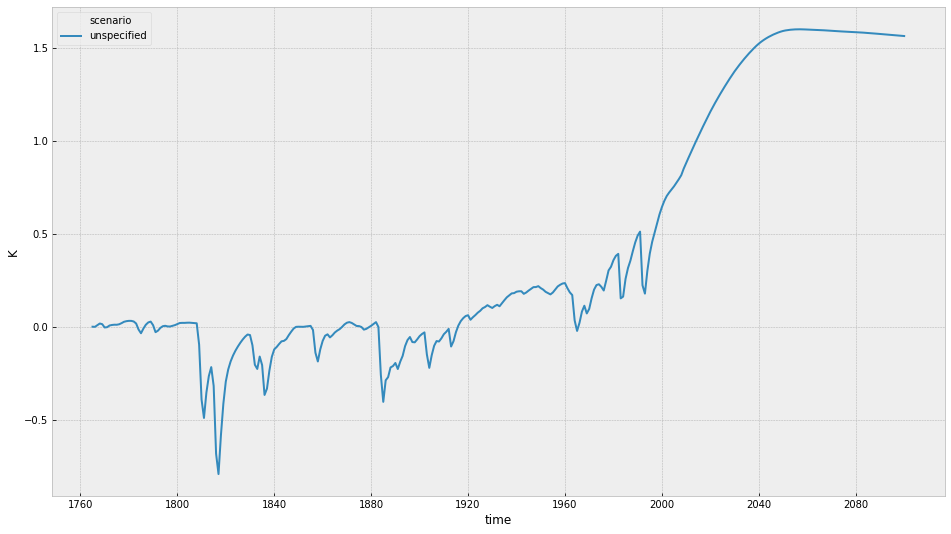

In [14]:
plt.figure(figsize=(16, 9))
results.filter(variable="Surface Temperature", region="World").lineplot(
    x="time"
);

If we wish, we can also `MAGICCData`'s resample method to join our timeseries together with a linear interpolation over a given period. This allows us to use some base scenario, overwrite with a multitude of other scenarios but ensure they all have a common historical period and some roughly smooth transition. (At the moment the `resample` and `interpolate` methods are the only options, a far more complete solution would be to use the [Aneris](https://github.com/iiasa/aneris) package but this would also be far more difficult.)

In [15]:
rcp3pd_up_to_2005 = my_scen_hist.filter(year=range(1, 2006))
rcp85_2015_onwards = my_scen_future.filter(year=range(2015, 30000))
# TODO: fix openscm method so it checks for duplicate time points, not duplicate index...
# TODO: work out why resample and interpolate are so slow...
target_times = [datetime(y, 1, 1) for y in range(2000, 2501)]
linear_scen = rcp3pd_up_to_2005.append(
    rcp85_2015_onwards, duplicate_msg="warn"
).filter(
    region="World"
)  # .interpolate(target_times)

/home/jared/code/uom/pymagicc/venv/lib/python3.7/site-packages/scmdata/run.py:1985: UserWarning: Duplicate time points detected, the output will be the average of the duplicates.  Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)


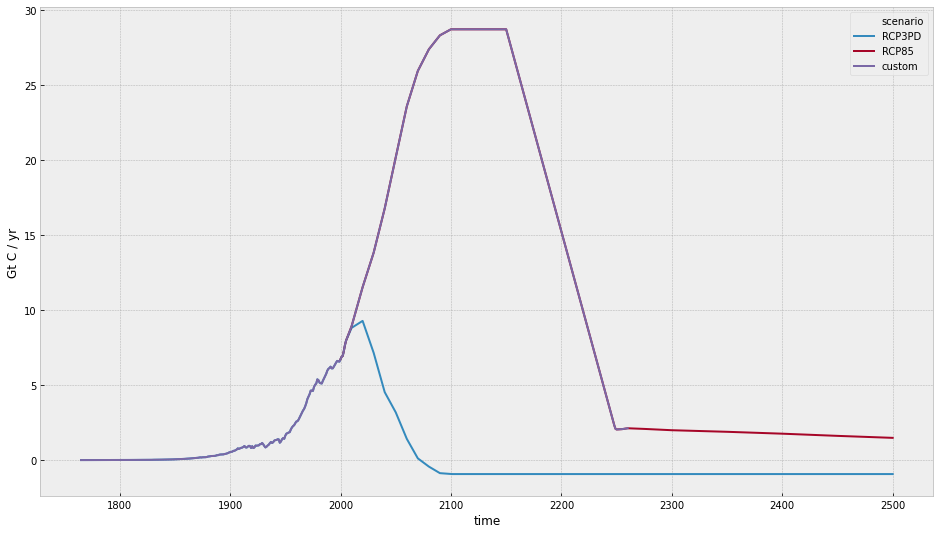

In [16]:
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

plt.figure(figsize=(16, 9))
run_append([rcp3pd, rcp85, my_scen_world]).filter(
    region="World", variable=var_to_plot
).lineplot(x="time", hue="scenario")
ax.set_xlim([datetime(2000, 1, 1), datetime(2031, 1, 1)])
ax.set_ylim([6.5, 15]);

In [17]:
with MAGICC6() as magicc:
    results = magicc.run(linear_scen)

/home/jared/code/uom/pymagicc/pymagicc/io/scen.py:254: UserWarning: Ignoring input data which is not required for .SCEN file
  warnings.warn("Ignoring input data which is not required for .SCEN file")


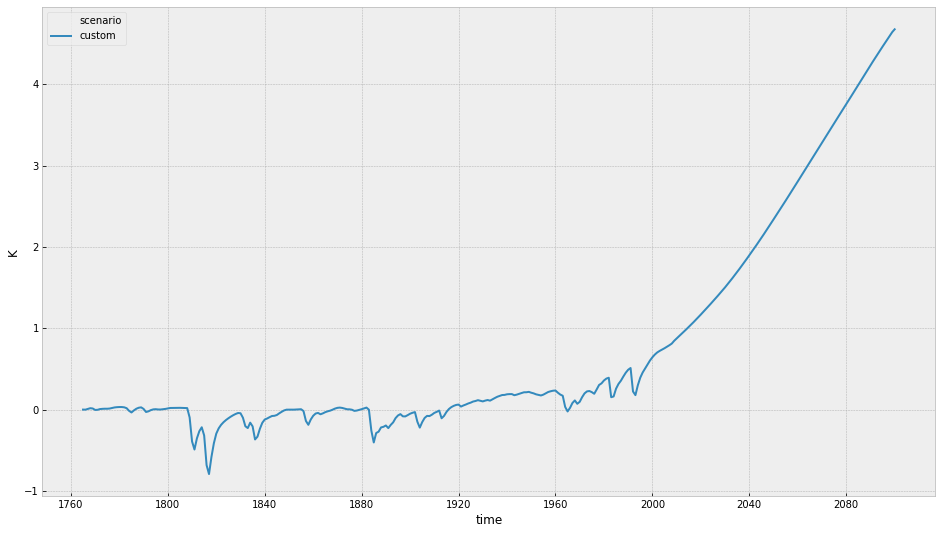

In [18]:
plt.figure(figsize=(16, 9))
results.filter(variable="Surface Temperature", region="World").line_plot(
    x="time",
);

## Warning

If you try to merge data which has no overlapping indices, you'll end up with `np.nan` in your output. For example, if we set our "todo" column to "N/A" in `base` (for an explanation of what this "todo" column is, see [file conventions](https://pymagicc.readthedocs.io/en/latest/file_conventions.html#columns)).

As a user, you have to check carefully that the merging has actually happened as intended (pull requests with convenience functions that can help automate these checks are most welcome!!). One easy way to do this is to simply see if any of the data in the output is null.

In [19]:
rcp85_2015_onwards_world = my_scen_future.filter(
    year=range(2015, 30000), region="World",
)
rcp3pd_up_to_2005_world = my_scen_hist.filter(
    year=range(1, 2006), region="World",
)

null_output = rcp3pd_up_to_2005_world.append(
    rcp85_2015_onwards_world, duplicate_msg="warn"
).timeseries()
null_output.isnull().any().any()

/home/jared/code/uom/pymagicc/venv/lib/python3.7/site-packages/scmdata/run.py:1985: UserWarning: Duplicate time points detected, the output will be the average of the duplicates.  Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)


True

There are still null values, we can see where they are with something like this.

In [20]:
null_output[null_output.isnull().any(axis=1)]

time                                                                                                       1765-01-01 00:00:00  \
model     scenario unit              variable                                   region todo climate_model                        
idealised custom   Gt C / yr         Emissions|CO2|MAGICC AFOLU                 World  SET  unspecified               0.000000   
                                     Emissions|CO2|MAGICC Fossil and Industrial World  SET  unspecified               0.003000   
                   Mt BC / yr        Emissions|BC                               World  SET  unspecified               0.000000   
                   Mt CH4 / yr       Emissions|CH4                              World  SET  unspecified               0.000000   
                   Mt CO / yr        Emissions|CO                               World  SET  unspecified               0.000000   
                   Mt N / yr         Emissions|NH3                              World  SET  unspecified               0.833837   
                                     Emissions|NOx                              World  SET  unspecified               0.000000   
                   Mt N2ON / yr      Emissions|N2O                              World  SET  unspecified               0.000000   
                   Mt NMVOC / yr     Emissions|NMVOC                            World  SET  unspecified               0.000000   
                   Mt OC / yr        Emissions|OC                               World  SET  unspecified               0.000000   
                   Mt S / yr         Emissions|SOx                              World  SET  unspecified               0.000000   
                   kt C2F6 / yr      Emissions|C2F6                             World  SET  unspecified               0.000000   
                   kt C6F14 / yr     Emissions|C6F14                            World  SET  unspecified               0.000000   
                   kt CCl4 / yr      Emissions|CCl4                             World  SET  unspecified               0.000000   
                   kt CF4 / yr       Emissions|CF4                              World  SET  unspecified               0.010763   
                   kt CFC11 / yr     Emissions|CFC11                            World  SET  unspecified               0.000000   
                   kt CFC113 / yr    Emissions|CFC113                           World  SET  unspecified               0.000000   
                   kt CFC114 / yr    Emissions|CFC114                           World  SET  unspecified               0.000000   
                   kt CFC115 / yr    Emissions|CFC115                           World  SET  unspecified               0.000000   
                   kt CFC12 / yr     Emissions|CFC12                            World  SET  unspecified               0.000000   
                   kt CH3Br / yr     Emissions|CH3Br                            World  SET  unspecified             157.267000   
                   kt CH3CCl3 / yr   Emissions|CH3CCl3                          World  SET  unspecified               0.000000   
                   kt CH3Cl / yr     Emissions|CH3Cl                            World  SET  unspecified            3100.211000   
                   kt HCFC141b / yr  Emissions|HCFC141b                         World  SET  unspecified               0.000000   
                   kt HCFC142b / yr  Emissions|HCFC142b                         World  SET  unspecified               0.000000   
                   kt HCFC22 / yr    Emissions|HCFC22                           World  SET  unspecified               0.000000   
                   kt HFC125 / yr    Emissions|HFC125                           World  SET  unspecified               0.000000   
                   kt HFC134a / yr   Emissions|HFC134a                          World  SET  unspecified               0.000000   
                   kt HFC143a / yr   Emissions|HFC143a                          World  SET  unspecif

This makes it clear that all of the non-SCEN gases have `np.nan` values into the future, which makes sense as the SCEN file does not define them. 

If we drop these variables first, i.e. do the merge carefully, none of the null values appear.

In [21]:
rcp85_2015_onwards_world = my_scen_future.filter(
    year=range(2015, 30000), region="World"
)
rcp3pd_up_to_2005_world_careful = my_scen_hist.filter(
    year=range(1, 2006),
    region="World",
    variable=rcp85_2015_onwards_world["variable"],
)

no_nulls = rcp3pd_up_to_2005_world_careful.append(
    rcp85_2015_onwards_world, duplicate_msg="warn"
)
no_nulls.timeseries().isnull().any().any()

/home/jared/code/uom/pymagicc/venv/lib/python3.7/site-packages/scmdata/run.py:1985: UserWarning: Duplicate time points detected, the output will be the average of the duplicates.  Set `duplicate_msg=False` to silence this message.
  warnings.warn(warn_msg)


True

As a side effect, running MAGICC with this scenario does not produce any warning about ignoring data.

In [22]:
with MAGICC6() as magicc:
    results = magicc.run(linear_scen)